In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df



In [4]:
def train_model(df):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.fit(df)
    return model



In [ ]:
def train_model(df):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='multiplicative')
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.add_regressor('county_effect')  # Adding the county effect as a regressor
    model.fit(df)
    return model


In [5]:
def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future



In [6]:
def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse



In [7]:
def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    #ax.plot(forecast_historical['ds'], forecast_historical['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders (Train)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    #ax.plot(forecast_future['ds'], forecast_future['yhat'], marker='o', linestyle='--', label='Predicted Bad Orders (Future)')
    #ax.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='gray', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [8]:
# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 51 non-null     datetime64[ns]
 1   Fleets_in_Service  51 non-null     float64       
 2   Bad_orders         51 non-null     int64         
 3   y                  51 non-null     int64         
 4   Paid_Storage       51 non-null     int64         
 5   month              51 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3)
memory usage: 2.3 KB


In [10]:
df.head()

,ds,Fleets_in_Service,Bad_orders,y,Paid_Storage,month
0,2022-10-01,46088.262272,57,1344,273,10
1,2022-11-01,46031.636754,79,1177,291,11
2,2022-12-01,42783.989750,84,1399,372,12
3,2023-01-01,41647.896564,75,1386,372,1
4,2023-02-01,41701.307188,75,1329,324,2


In [11]:
df.dtypes

ds                   datetime64[ns]
Fleets_in_Service           float64
Bad_orders                    int64
y                             int64
Paid_Storage                  int64
month                         int32
dtype: object

In [12]:
df['Fleets_in_Service'] =  df['Fleets_in_Service'].astype(int)

In [13]:
# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)


21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
import pickle

In [17]:
# save the model 
filename = 'linear_model.sav'
pickle.dump(model, open(filename, 'wb')) 

In [14]:
test_df.head()

,ds,Fleets_in_Service,Bad_orders,y,Paid_Storage,month
39,2026-01-01,42359,64,1116,411,1
40,2026-02-01,40530,70,1197,297,2
41,2026-03-01,41267,83,1023,341,3
42,2026-04-01,42658,65,878,324,4
43,2026-05-01,43504,56,953,410,5


In [15]:
# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)  # No future periods needed for historical

MAE: 202.47259897139847
MSE: 68755.51554020014
RMSE: 262.2127295540782


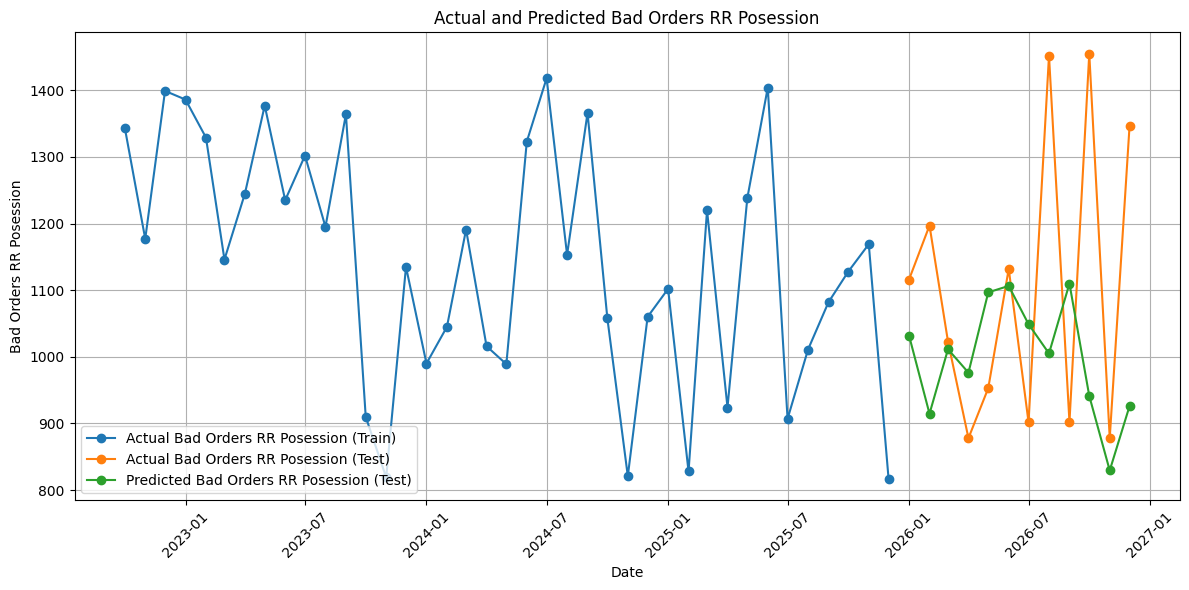

           ds         yhat  yhat_lower   yhat_upper
0  2026-01-01  1031.977388  887.623729  1177.171895
1  2026-02-01   914.622247  747.152639  1065.713558
2  2026-03-01  1011.393892  867.257919  1170.711064
3  2026-04-01   976.251550  834.537975  1134.192933
4  2026-05-01  1096.780369  939.085950  1248.706508
5  2026-06-01  1106.399625  955.422823  1251.248936
6  2026-07-01  1049.062653  891.516827  1196.504901
7  2026-08-01  1005.083929  863.008102  1153.140847
8  2026-09-01  1109.994523  971.788179  1262.798951
9  2026-10-01   941.355952  800.348214  1091.245443
10 2026-11-01   829.525116  677.592479   975.311671
11 2026-12-01   926.059758  771.424844  1072.950247


In [56]:
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds','yhat', 'yhat_lower', 'yhat_upper']])

Analysis of Results
MAE of 202.47: This suggests that, on average, 
the model's predictions are off by about 202.47 bad orders RR Possession. 
For your application, this may or may not be acceptable depending on the typical scale of bad orders RR Possession.

MSE of 68755.52: This high value indicates that there are some large errors in the model's predictions. 
Squaring the errors exaggerates the effect of larger errors, leading to a higher value.

RMSE of 262.21: This metric, being in the same units as the data, is more interpretable. 
It indicates that the typical deviation from the actual values is around 262.21 bad orders.

C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

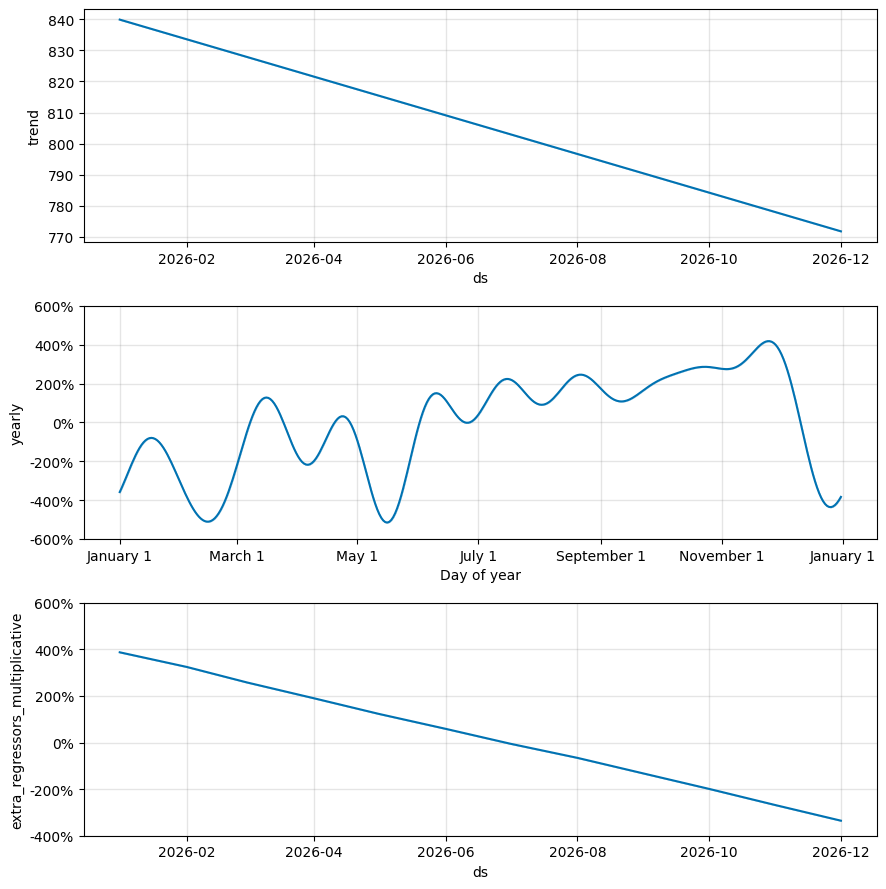

In [53]:
fig = model.plot_components(forecast_test)
plt.show()

Trend Component:If the trend line is upward, it suggests that the number of Bad_orders RR Posession is generally increasing over time.
If downward, it suggests a decrease.

Yearly Seasonality Component:Peaks in specific months suggest higher Bad_orders RR Posession during those months.
Troughs indicate lower Bad_orders RR Posession in other months.

Regressors:Shows how changes in Fleets_in_Service influence Bad_orders RR Posession.
If the plot for Fleets_in_Service shows an upward slope, it means that as the fleet size increases, the number of Bad_orders also increases.

# Adding Country effect with this dataset

In [6]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df
	
def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='multiplicative',
        holidays=None
    )
    
    model.add_country_holidays(country_name='US')
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.fit(df)
    return model

	
def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future
	
def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse
	
def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    #ax.plot(forecast_historical['ds'], forecast_historical['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders (Train)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    #ax.plot(forecast_future['ds'], forecast_future['yhat'], marker='o', linestyle='--', label='Predicted Bad Orders (Future)')
    #ax.fill_between(forecast_future['ds'], forecast_future['yhat_lower'], forecast_future['yhat_upper'], color='gray', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
	
# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] =  df['Fleets_in_Service'].astype(int)



In [7]:
# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)




In [8]:
# Step 3: Train the model
model = train_model(train_df)


14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:55 - cmdstanpy - INFO - Chain [1] done processing


MAE: 202.88123339153435
MSE: 64595.30431454765
RMSE: 254.15606291125076


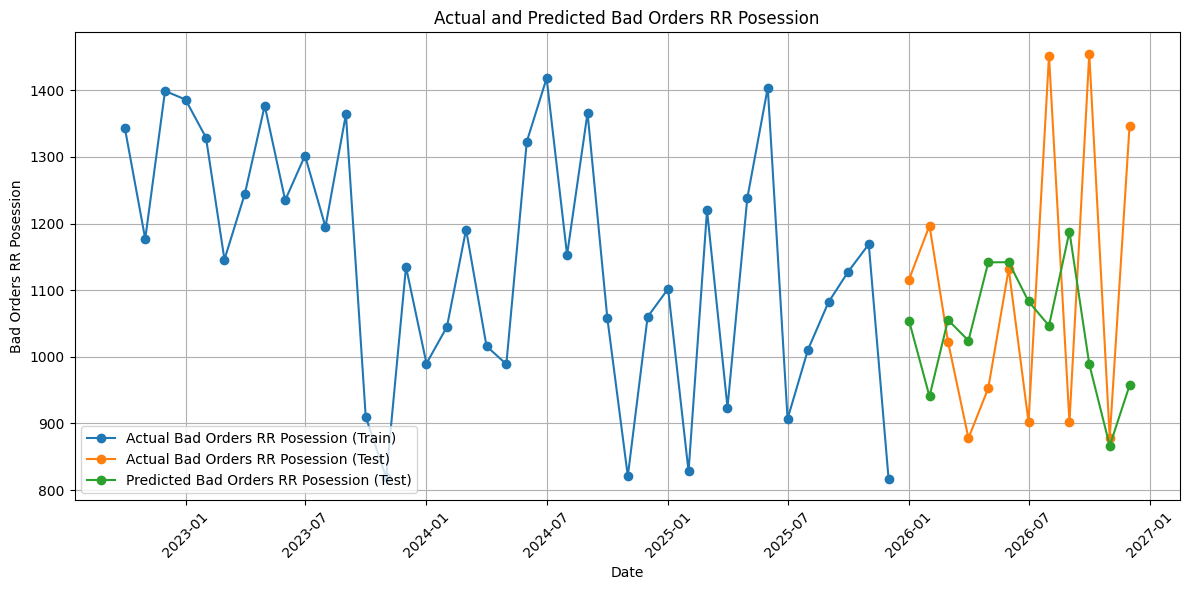

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1054.134459   925.695741  1199.034332
1  2026-02-01   940.605543   790.601432  1081.092404
2  2026-03-01  1055.430904   914.946739  1207.227955
3  2026-04-01  1024.332664   877.281654  1171.612412
4  2026-05-01  1141.818448   998.788330  1302.024267
5  2026-06-01  1142.010866   977.850448  1274.685207
6  2026-07-01  1083.194864   939.397933  1220.646446
7  2026-08-01  1046.684212   892.096087  1195.532722
8  2026-09-01  1187.790350  1032.507355  1334.506819
9  2026-10-01   989.005403   851.206372  1137.719651
10 2026-11-01   866.533201   725.589816  1023.220122
11 2026-12-01   957.040477   801.522524  1092.170447


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

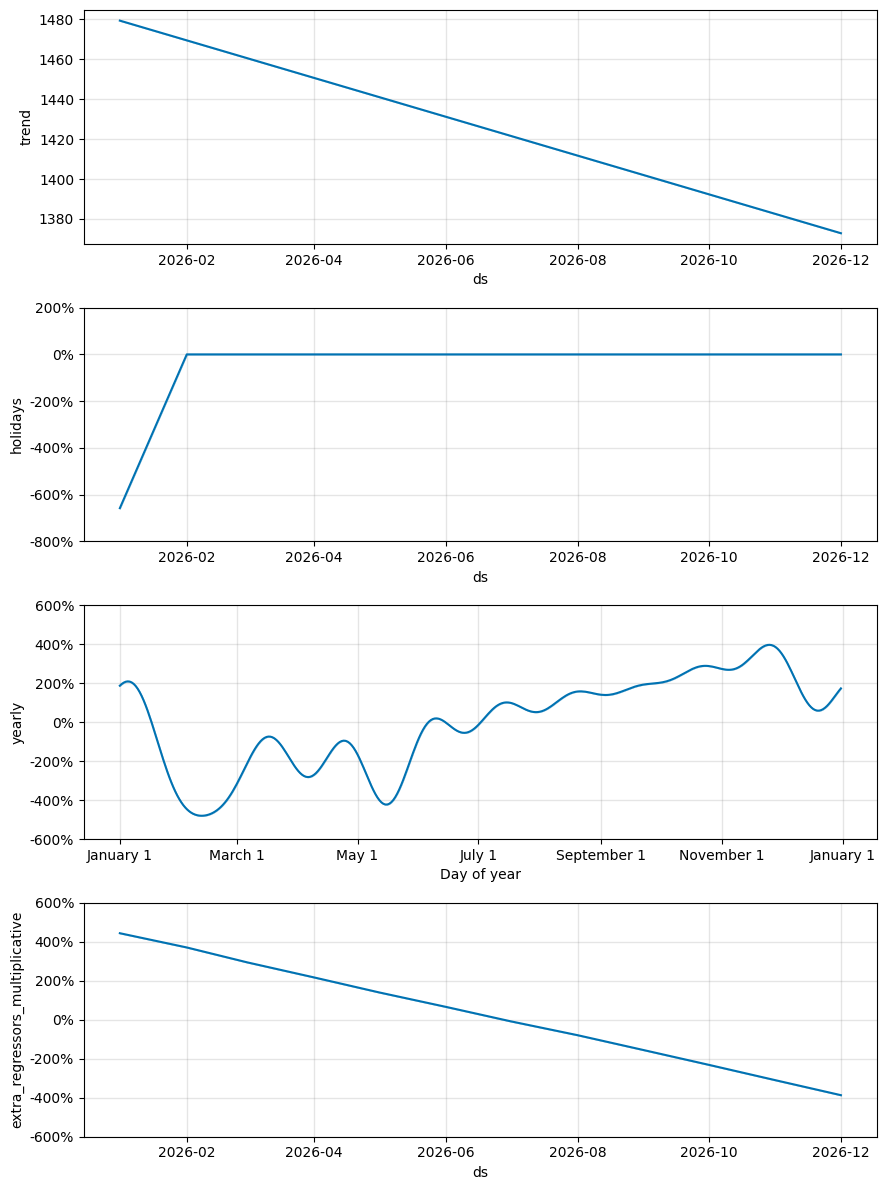

In [9]:
# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12) 
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds','yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()

# Adding county effect to US

14:41:22 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing


MAE: 202.17416249150585
MSE: 64191.422886819695
RMSE: 253.3602630382667


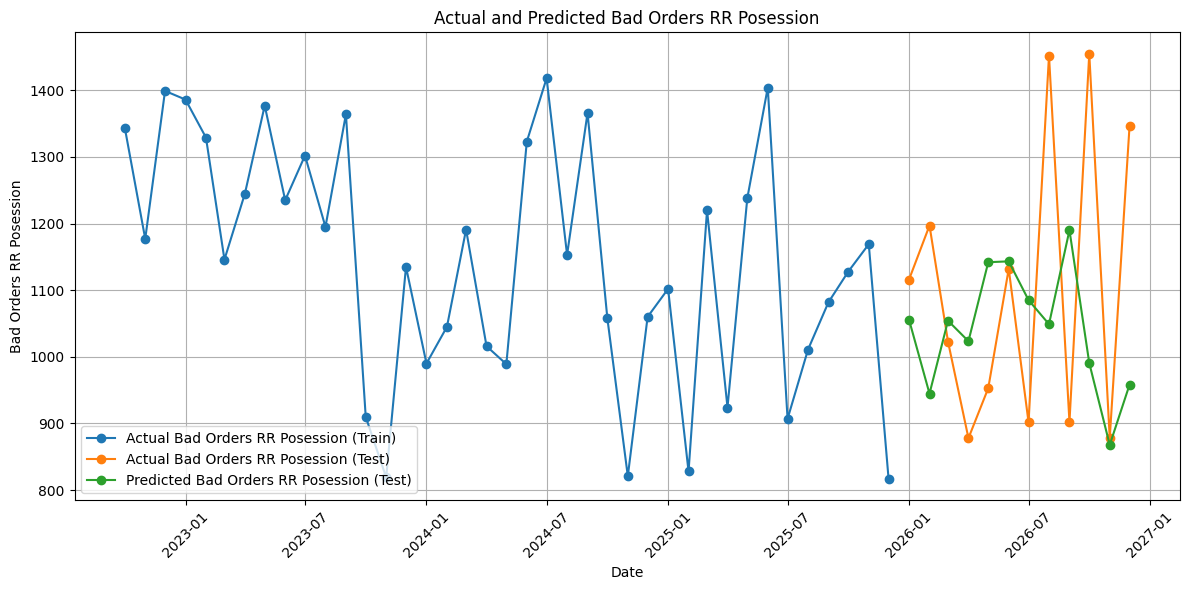

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1055.680571   906.594696  1203.933464
1  2026-02-01   944.802377   790.318324  1088.587969
2  2026-03-01  1054.216463   908.347904  1218.382367
3  2026-04-01  1023.484241   893.272226  1175.391937
4  2026-05-01  1142.011178   982.916028  1291.640734
5  2026-06-01  1143.272858   991.689687  1294.456093
6  2026-07-01  1085.199352   941.071340  1237.018392
7  2026-08-01  1048.996794   898.142495  1191.458536
8  2026-09-01  1190.075876  1040.366017  1334.164337
9  2026-10-01   990.730850   827.110873  1134.452943
10 2026-11-01   867.841138   730.840813  1019.759048
11 2026-12-01   958.118289   807.814185  1097.534126


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

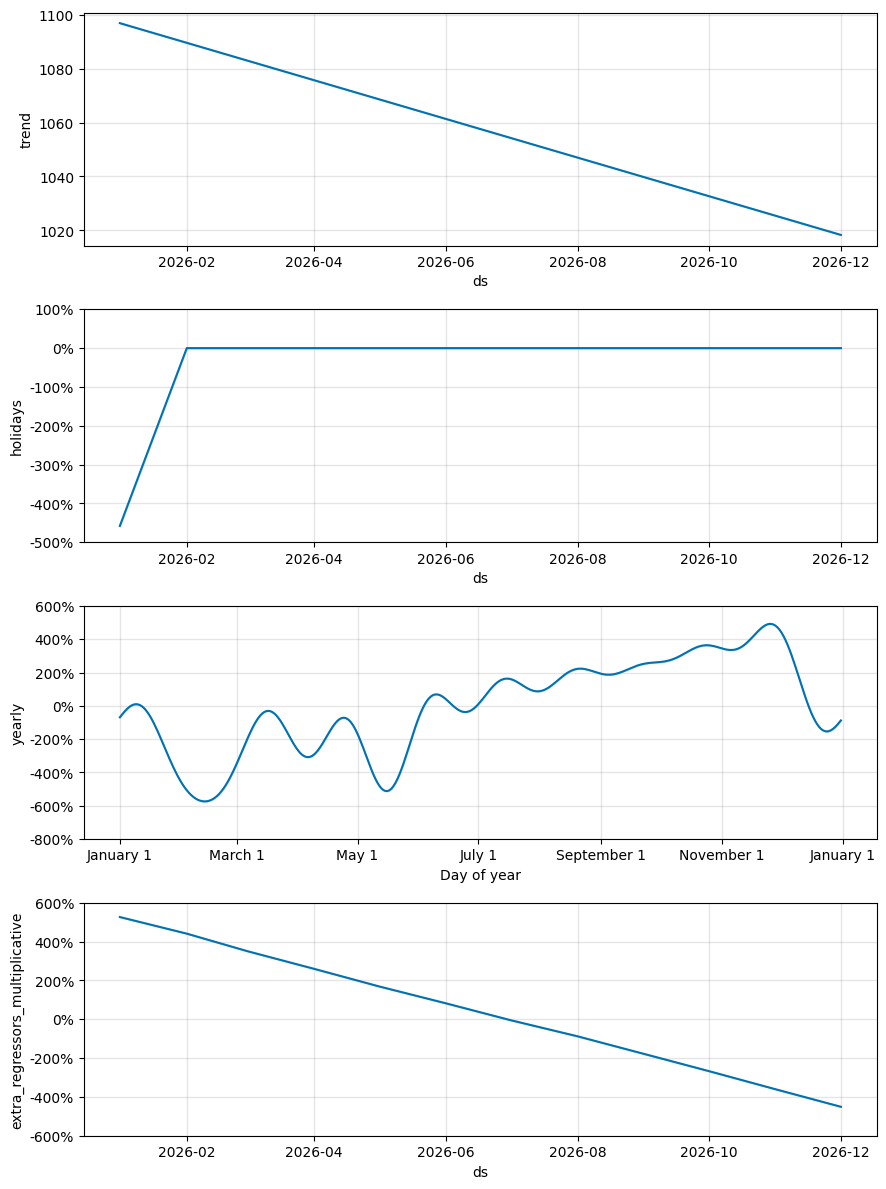

In [10]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='multiplicative'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.add_regressor('county_effect')  # Adding the county effect as a regressor
    model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month', 'county_effect']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    future['county_effect'] = df['county_effect'].iloc[-1]  # Use the latest available value
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()


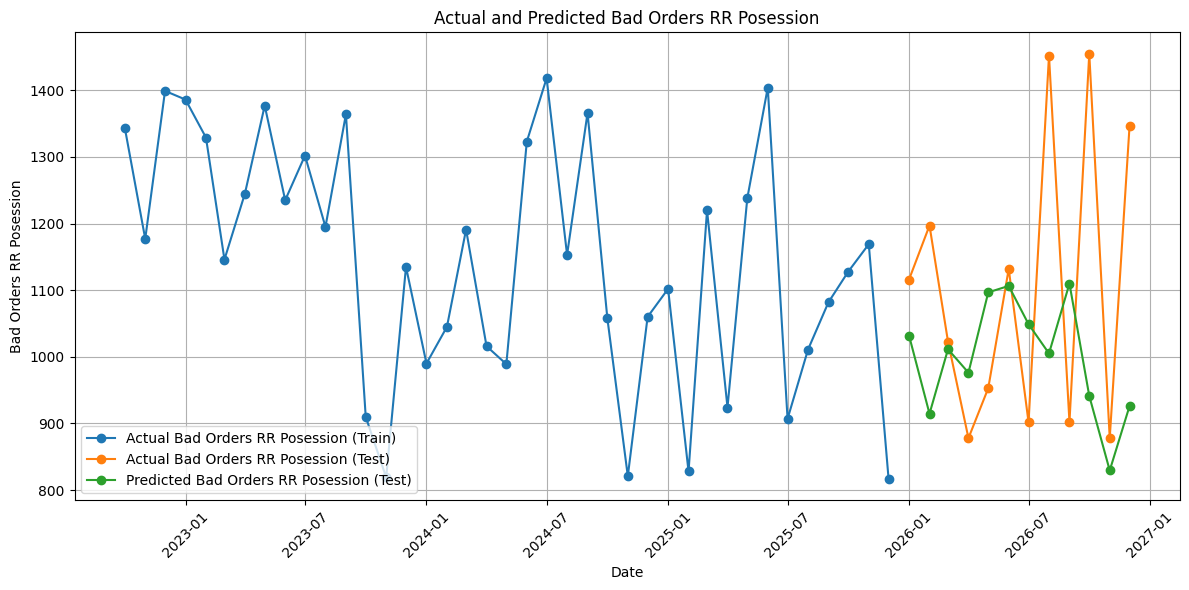

In [22]:
# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Adding addictive model


14:47:30 - cmdstanpy - INFO - Chain [1] start processing
14:47:30 - cmdstanpy - INFO - Chain [1] done processing


MAE: 215.85018660722653
MSE: 67775.00579133404
RMSE: 260.33633206168906


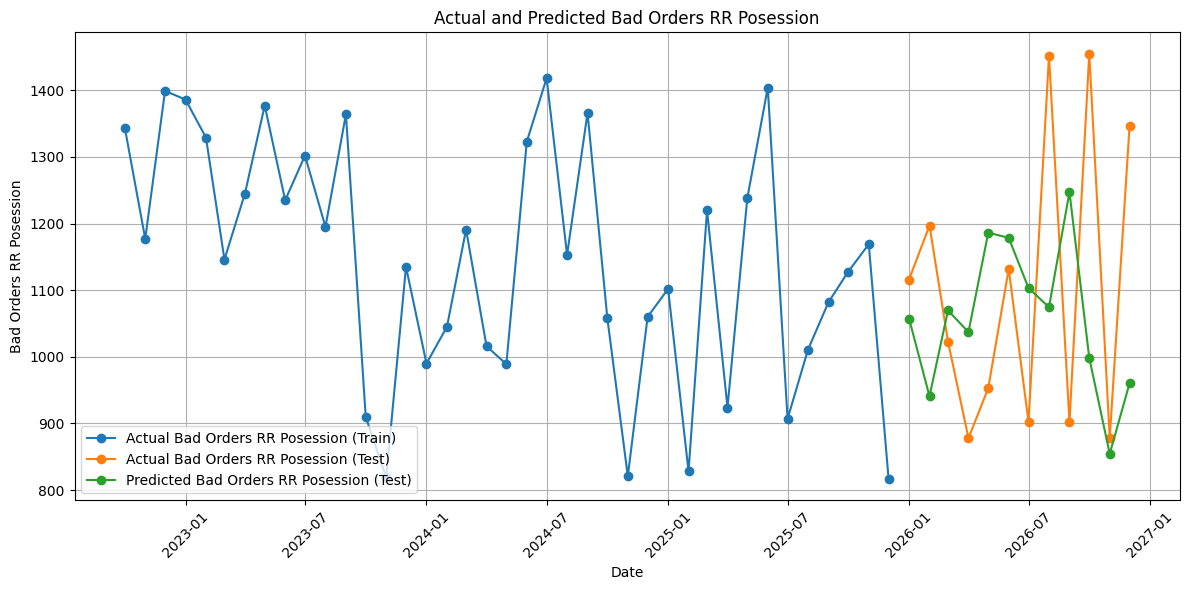

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1057.449045   911.572713  1211.303988
1  2026-02-01   940.857566   805.603311  1083.348997
2  2026-03-01  1069.671221   928.591025  1215.763350
3  2026-04-01  1037.101969   887.955499  1170.298402
4  2026-05-01  1186.308755  1043.887622  1326.476467
5  2026-06-01  1178.560799  1025.559225  1317.180668
6  2026-07-01  1103.200623   959.942632  1246.395804
7  2026-08-01  1074.531276   937.615195  1217.248049
8  2026-09-01  1247.297230  1116.104834  1403.673928
9  2026-10-01   998.345558   851.716194  1136.964782
10 2026-11-01   854.625671   714.258884  1008.682771
11 2026-12-01   960.129241   818.120380  1100.559021


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

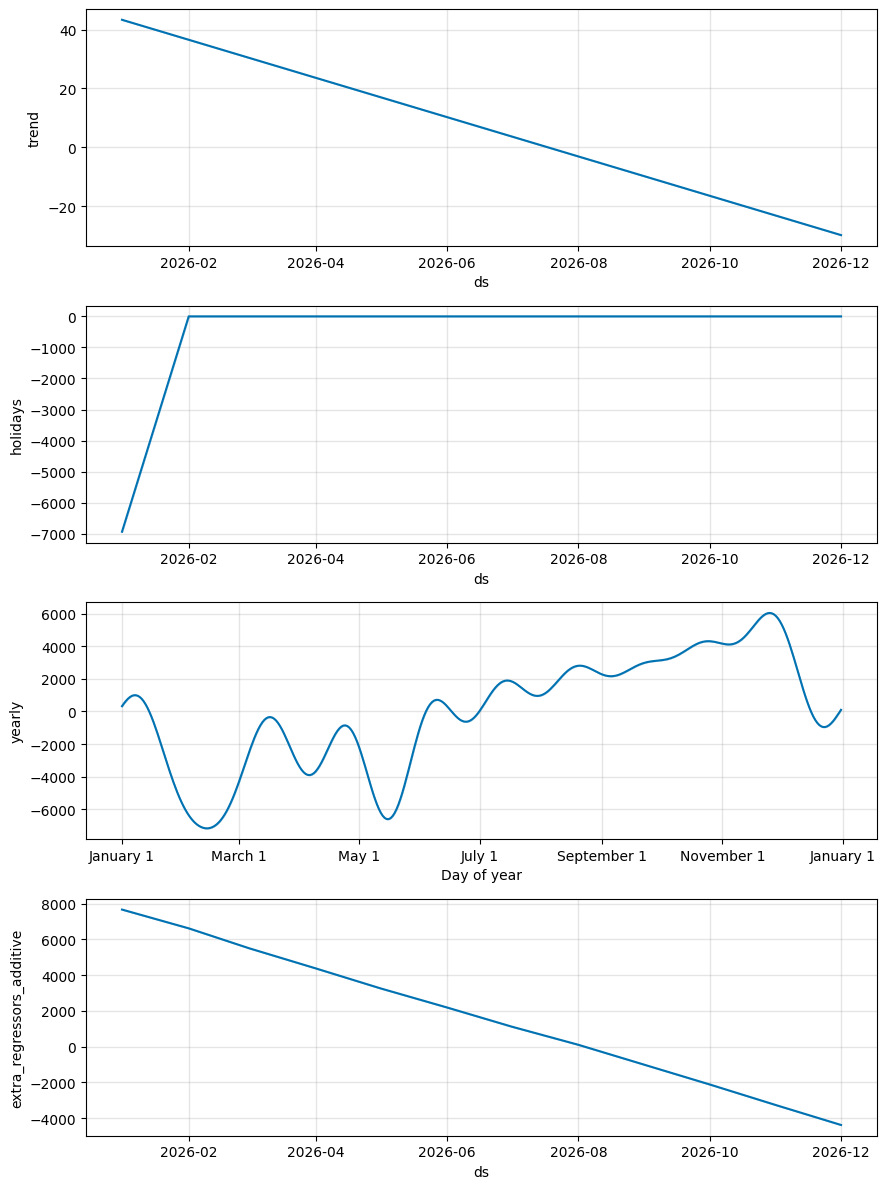

In [11]:
#import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='additive'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.add_regressor('county_effect')  # Adding the county effect as a regressor
    model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month', 'county_effect']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    future['county_effect'] = df['county_effect'].iloc[-1]  # Use the latest available value
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()


# Adding growth='linear', growth_floor=0.0 

15:01:56 - cmdstanpy - INFO - Chain [1] start processing
15:01:57 - cmdstanpy - INFO - Chain [1] done processing


MAE: 202.88123339153435
MSE: 64595.30431454765
RMSE: 254.15606291125076


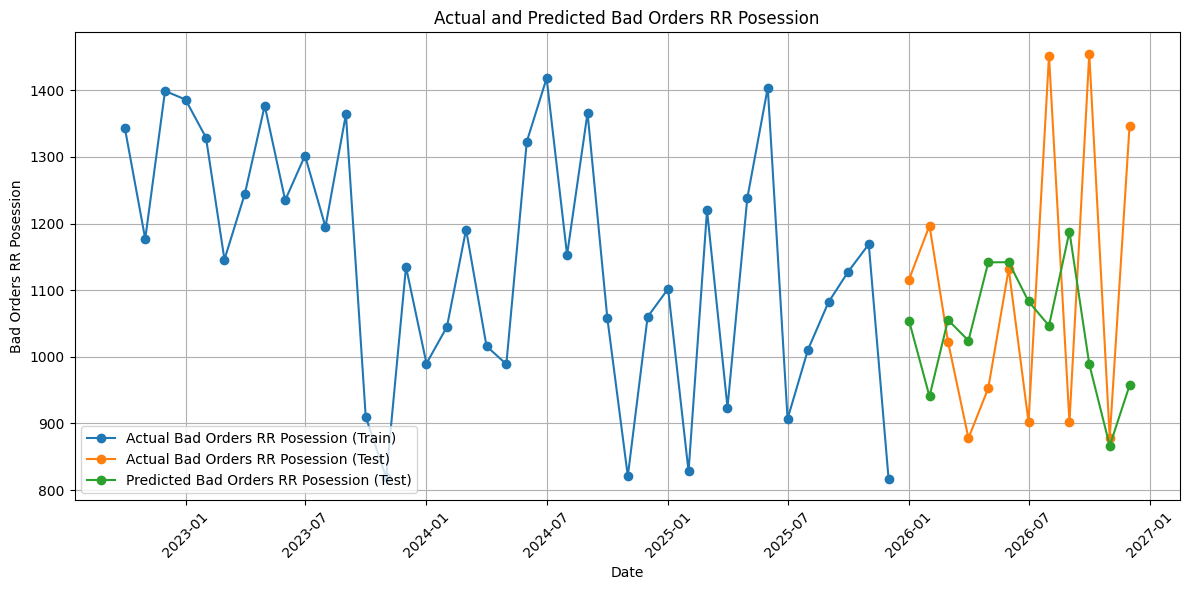

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1054.134459   907.768054  1192.748876
1  2026-02-01   940.605543   786.186524  1076.594245
2  2026-03-01  1055.430904   912.029664  1199.541246
3  2026-04-01  1024.332664   877.962886  1174.953168
4  2026-05-01  1141.818448   993.422453  1287.466655
5  2026-06-01  1142.010866  1008.876183  1290.997374
6  2026-07-01  1083.194864   927.671523  1222.946693
7  2026-08-01  1046.684212   885.093254  1194.566986
8  2026-09-01  1187.790350  1042.399783  1330.584855
9  2026-10-01   989.005403   843.630998  1120.570161
10 2026-11-01   866.533201   714.582537  1017.777101
11 2026-12-01   957.040477   817.013121  1104.760348


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

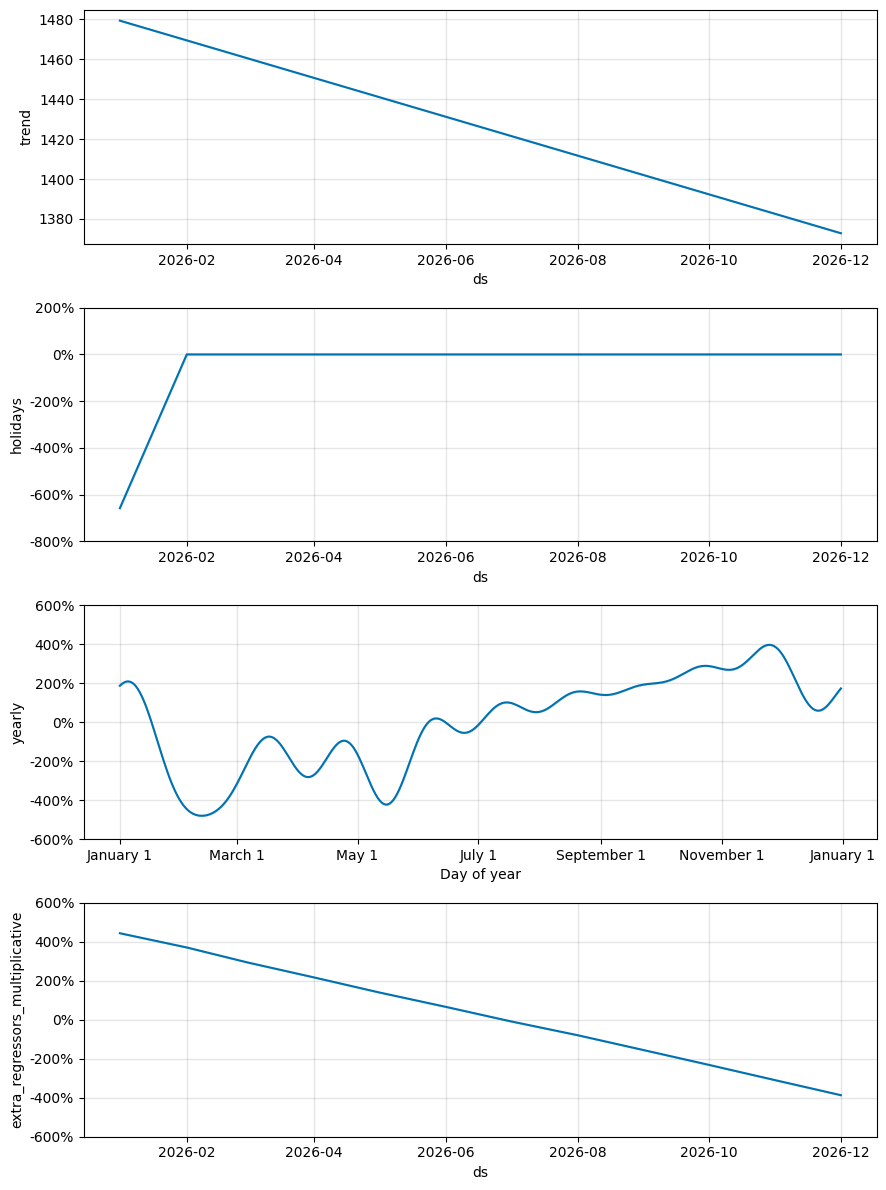

In [12]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='multiplicative',
        growth='linear'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    #model.add_regressor('county_effect')  # Adding the county effect as a regressor
    model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month', 'county_effect']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    future['county_effect'] = df['county_effect'].iloc[-1]  # Use the latest available value
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()


# Adding growth='linear', growth_floor=0.0 and seasonality_mode='additive'

15:05:04 - cmdstanpy - INFO - Chain [1] start processing
15:05:05 - cmdstanpy - INFO - Chain [1] done processing


MAE: 215.7875672219345
MSE: 67661.43946015433
RMSE: 260.11812597386273


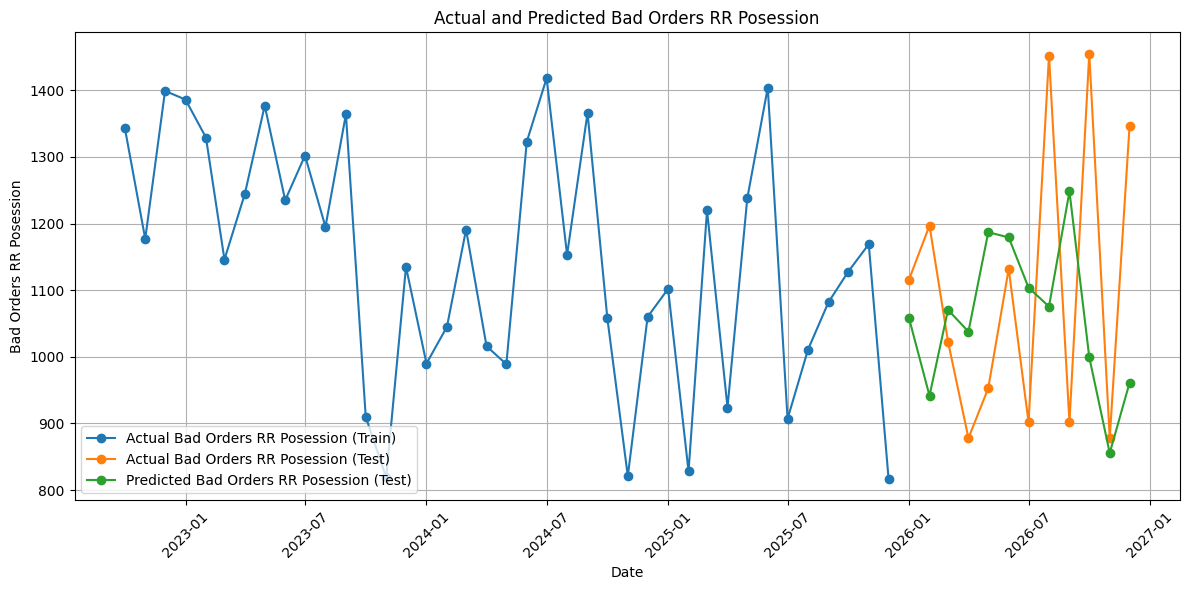

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1057.855082   905.554982  1186.485797
1  2026-02-01   941.716662   800.382813  1079.268512
2  2026-03-01  1070.470899   922.970123  1213.659714
3  2026-04-01  1037.897115   894.695704  1187.670569
4  2026-05-01  1186.994825  1028.771984  1337.713136
5  2026-06-01  1179.185280  1037.928737  1326.228238
6  2026-07-01  1103.919756   956.870353  1252.944504
7  2026-08-01  1075.468000   929.437298  1232.985572
8  2026-09-01  1248.177565  1097.810599  1395.976662
9  2026-10-01   999.521994   856.089180  1139.875699
10 2026-11-01   855.652079   705.624974  1006.826334
11 2026-12-01   960.980816   819.065430  1108.558441


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

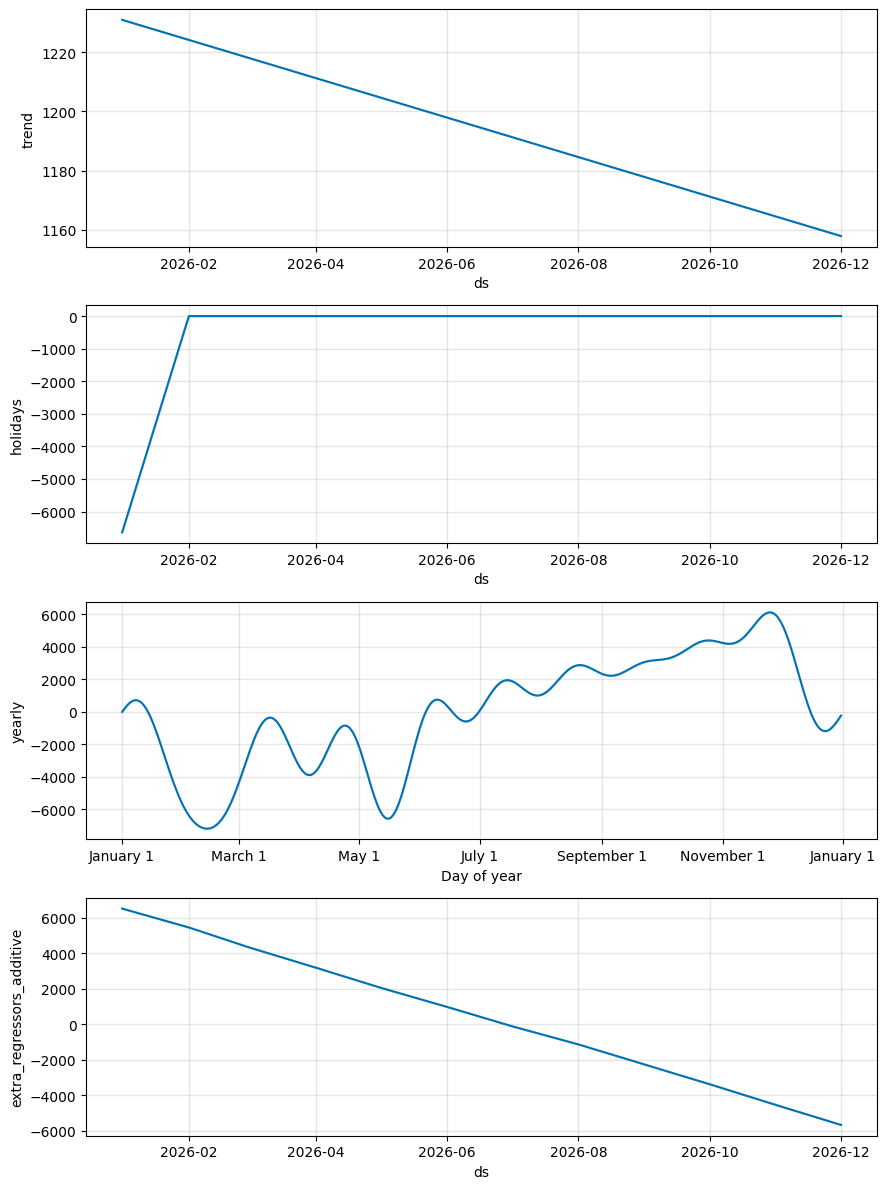

In [13]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='additive',
        growth='linear'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month', 'county_effect']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()


# Cross Validation


16:30:22 - cmdstanpy - INFO - Chain [1] start processing
16:30:22 - cmdstanpy - INFO - Chain [1] done processing


MAE: 202.88123339153435
MSE: 64595.30431454765
RMSE: 254.15606291125076


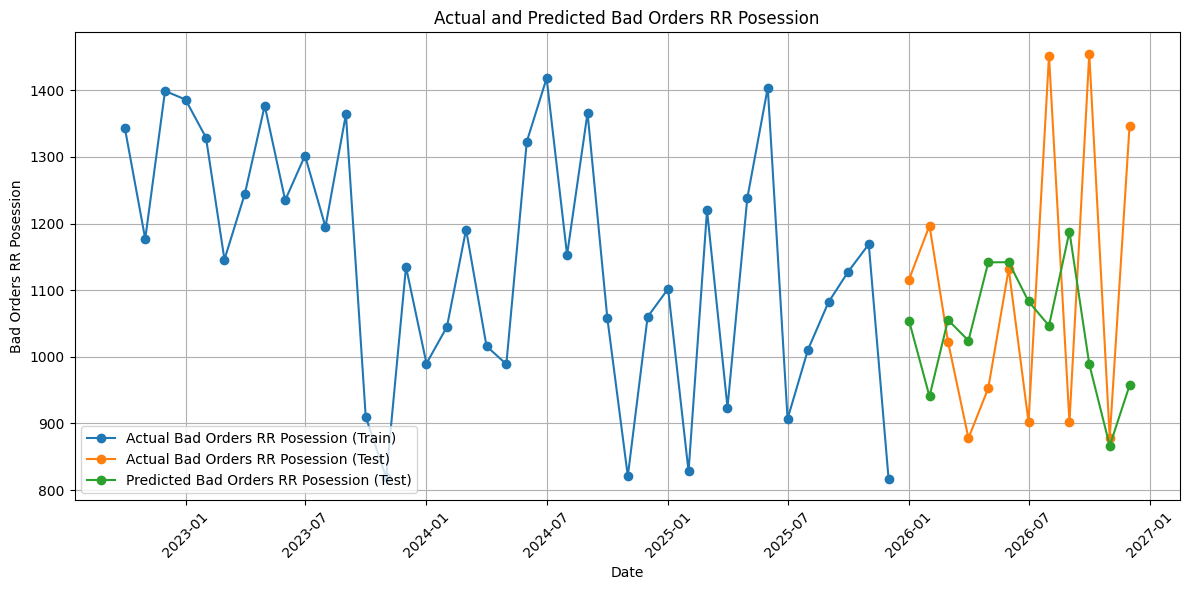

           ds         yhat   yhat_lower   yhat_upper
0  2026-01-01  1054.134459   903.130790  1192.963869
1  2026-02-01   940.605543   795.895960  1093.274148
2  2026-03-01  1055.430904   912.783067  1201.648691
3  2026-04-01  1024.332664   877.966842  1172.848187
4  2026-05-01  1141.818448   986.228907  1282.793414
5  2026-06-01  1142.010866   981.743368  1286.066665
6  2026-07-01  1083.194864   945.448505  1237.638995
7  2026-08-01  1046.684212   909.885115  1186.209862
8  2026-09-01  1187.790350  1048.433190  1331.145853
9  2026-10-01   989.005403   839.818719  1124.331870
10 2026-11-01   866.533201   727.019533  1007.673981
11 2026-12-01   957.040477   814.103108  1113.404000


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

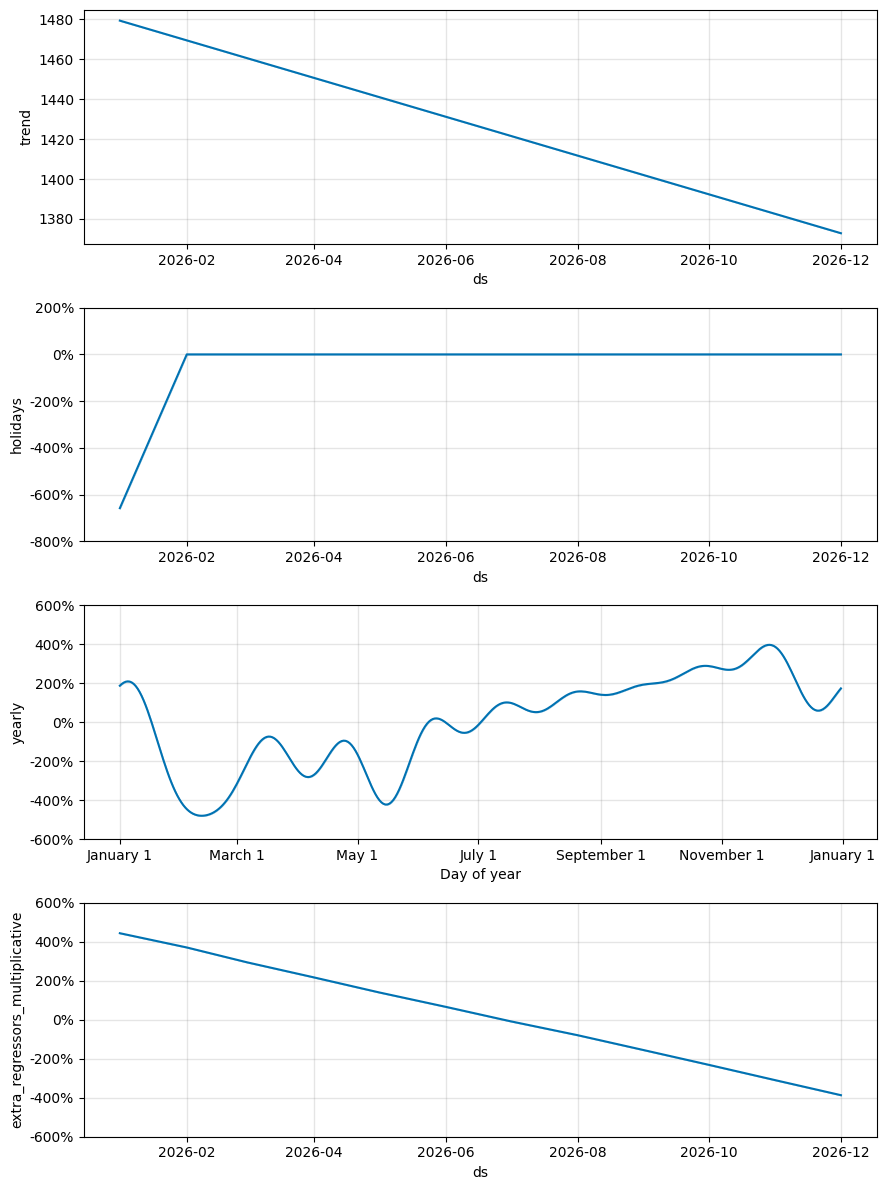

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


    horizon            mse        rmse         mae      mape     mdape  \
0   31 days    4369.615258   66.103065   66.103065  0.059985  0.059985   
1   62 days   48028.308342  219.153618  219.153618  0.264678  0.264678   
2   90 days   68935.130619  262.555005  262.555005  0.215209  0.215209   
3  121 days    3380.920781   58.145686   58.145686  0.062928  0.062928   
4  151 days  118211.513207  343.819012  343.819012  0.277721  0.277721   
5  182 days  149267.016328  386.350898  386.350898  0.275179  0.275179   
6  212 days   34374.201503  185.402809  185.402809  0.204413  0.204413   
7  243 days    5091.611726   71.355530   71.355530  0.070579  0.070579   
8  274 days   20408.011861  142.856613  142.856613  0.132030  0.132030   
9  304 days  231848.268392  481.506250  481.506250  0.426867  0.426867   
10 335 days  363401.856572  602.828215  602.828215  0.515679  0.515679   
11 365 days    1114.152725   33.378926   33.378926  0.040855  0.040855   

       smape  coverage  
0   0.058238

In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='multiplicative',
        growth='linear'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    #model.add_regressor('county_effect')  # Adding the county effect as a regressor
    model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month', 'county_effect']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    #future['county_effect'] = df['county_effect'].iloc[-1]  # Use the latest available value
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()


In [17]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='90 days')

# Compute performance metrics
df_performance = performance_metrics(df_cv)
print(df_performance)


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|█████████████████████                                                               | 1/4 [00:08<00:24,  8.23s/it]16:34:44 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|██████████████████████████████████████████                                          | 2/4 [00:37<00:41, 20.52s/it]16:35:13 - cmdstanpy - INFO - Chain [1] start processing
16:35:14 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:37<00:11, 11.43s/it]16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - I

   horizon            mse        rmse         mae      mape     mdape  \
0  21 days  217373.567296  466.233383  466.233383  0.458891  0.458891   
1  24 days  248512.760099  498.510542  498.510542  0.471182  0.471182   
2  26 days   41402.752897  203.476664  203.476664  0.220213  0.220213   
3  29 days   56766.298120  238.256790  238.256790  0.211221  0.211221   
4  51 days  133107.771954  364.839378  364.839378  0.368897  0.368897   
5  55 days  234271.827233  484.016350  484.016350  0.589545  0.589545   
6  56 days    5882.077222   76.694701   76.694701  0.061950  0.061950   
7  60 days  187813.845390  433.374948  433.374948  0.370723  0.370723   
8  82 days   32144.473098  179.288798  179.288798  0.135517  0.135517   
9  85 days    1423.882137   37.734363   37.734363  0.035598  0.035598   
10 87 days     570.208259   23.879034   23.879034  0.017008  0.017008   
11 90 days   16889.673953  129.960278  129.960278  0.159070  0.159070   

       smape  coverage  
0   0.595534       0.0  


16:38:25 - cmdstanpy - INFO - Chain [1] start processing
16:38:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 202.47259897139847
MSE: 68755.51554020014
RMSE: 262.2127295540782


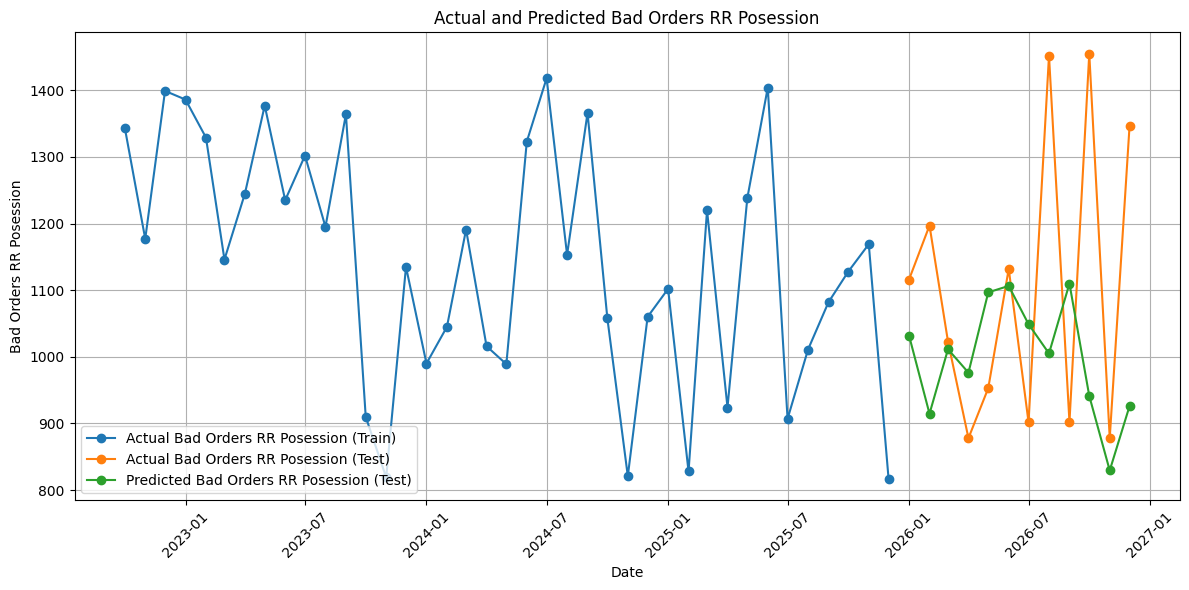

           ds         yhat  yhat_lower   yhat_upper
0  2026-01-01  1031.977388  886.549420  1185.866567
1  2026-02-01   914.622247  760.106630  1068.976580
2  2026-03-01  1011.393892  866.220696  1163.597104
3  2026-04-01   976.251550  832.821244  1139.407627
4  2026-05-01  1096.780369  949.486883  1251.824344
5  2026-06-01  1106.399625  969.852812  1266.563994
6  2026-07-01  1049.062653  899.130737  1211.597927
7  2026-08-01  1005.083929  858.487119  1154.289641
8  2026-09-01  1109.994523  970.879600  1261.996213
9  2026-10-01   941.355952  794.214701  1090.039898
10 2026-11-01   829.525116  672.435389   985.522404
11 2026-12-01   926.059758  774.971196  1070.151363


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

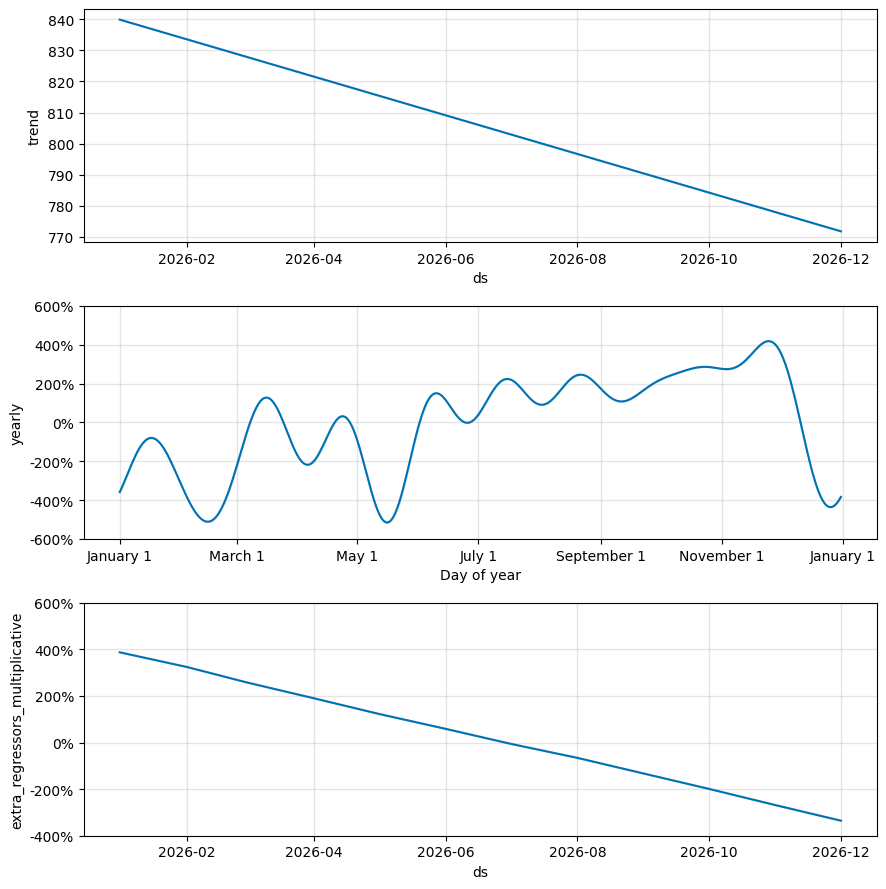

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]16:38:27 - cmdstanpy - INFO - Chain [1] start processing
16:38:30 - cmdstanpy - INFO - Chain [1] done processing
 25%|█████████████████████                                                               | 1/4 [00:03<00:11,  3.74s/it]16:38:30 - cmdstanpy - INFO - Chain [1] start processing
16:38:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|██████████████████████████████████████████                                          | 2/4 [00:13<00:15,  7.52s/it]16:38:41 - cmdstanpy - INFO - Chain [1] start processing
16:38:41 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:14<00:04,  4.23s/it]16:38:41 - cmdstanpy - INFO - Chain [1] start processing
16:38:41 - cmdstanpy - I

    horizon            mse        rmse         mae      mape     mdape  \
0   22 days  874386.155950  935.086176  907.188684  0.743500  0.743500   
1   26 days  675113.590270  821.652962  693.944376  0.515064  0.515064   
2   27 days  156858.607536  396.053794  376.599244  0.390438  0.390438   
3   51 days  212497.884486  460.974928  459.239388  0.475805  0.475805   
4   53 days  550198.173217  741.753445  690.419661  0.617594  0.617594   
5   57 days  570551.736241  755.348751  713.429188  0.697959  0.697959   
6   58 days  126797.320206  356.086113  328.948011  0.376228  0.376228   
7   80 days  119276.677279  345.364557  320.720962  0.283683  0.283683   
8   84 days  192017.879060  438.198447  438.065951  0.344833  0.344833   
9   85 days  116315.268896  341.050244  325.508111  0.248093  0.248093   
10  89 days   69005.064131  262.688150  260.150478  0.228740  0.228740   
11 111 days  541091.859358  735.589464  646.842384  0.627753  0.627753   
12 114 days  799902.428349  894.372645

In [21]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet.diagnostics import cross_validation, performance_metrics

def prepare_data(data):
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
    df['month'] = df['ds'].dt.month
    return df

def split_data(df, train_end_date):
    train_df = df[df['ds'] <= train_end_date]
    test_df = df[df['ds'] > train_end_date]
    return train_df, test_df

def train_model(df):
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=False, 
        daily_seasonality=False, 
        seasonality_mode='multiplicative',
        growth='linear'
    )
    model.add_regressor('Fleets_in_Service')
    model.add_regressor('month')
    #model.add_regressor('county_effect')  # Adding the county effect as a regressor
    #model.add_country_holidays(country_name='US')
    model.fit(df)
    return model

def make_predictions(model, df, future_periods=12):
    historical = df[['ds', 'Fleets_in_Service', 'month']]
    forecast_historical = model.predict(historical)

    future_dates = pd.date_range(start=df['ds'].max() + pd.DateOffset(months=1), periods=future_periods, freq='MS')
    future = pd.DataFrame({'ds': future_dates})
    future['Fleets_in_Service'] = df['Fleets_in_Service'].iloc[-1]  # Use the latest available value
    future['month'] = future['ds'].dt.month
    #future['county_effect'] = df['county_effect'].iloc[-1]  # Use the latest available value
    forecast_future = model.predict(future)

    return forecast_historical, forecast_future

def evaluate_model(df, forecast_historical):
    mae = mean_absolute_error(df['y'], forecast_historical['yhat'])
    mse = mean_squared_error(df['y'], forecast_historical['yhat'])
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_df['ds'], train_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Train)')
    ax.plot(test_df['ds'], test_df['y'], marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
    ax.plot(forecast_test['ds'], forecast_test['yhat'], marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Bad Orders RR Posession')
    ax.set_title('Actual and Predicted Bad Orders RR Posession')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main pipeline execution
data = pd.read_excel("TTX.xlsx")

# Step 1: Prepare the data
df = prepare_data(data)
df['Fleets_in_Service'] = df['Fleets_in_Service'].astype(int)
#df['county_effect'] = 1  # Replace with actual county effect values if available

# Step 2: Split the data
train_end_date = '2025-12-31'
train_df, test_df = split_data(df, train_end_date)

# Step 3: Train the model
model = train_model(train_df)

# Step 4: Make predictions
forecast_historical, _ = make_predictions(model, train_df, future_periods=12)
forecast_test, forecast_future = make_predictions(model, test_df)

# Step 5: Evaluate the model
mae, mse, rmse = evaluate_model(test_df, forecast_test)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Step 6: Plot the forecasts
plot_forecasts(train_df, test_df, forecast_historical, forecast_test, forecast_future)

# Display future forecasted values
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig = model.plot_components(forecast_test)
plt.show()

# Step 7: Cross-validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='180 days')
df_performance = performance_metrics(df_cv)
print(df_performance)


# Prepare LSTM Model


In [25]:
pip install keras


  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached optree-0.11.0-cp311-cp311-win_amd64.whl.metadata (46 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------- -------------------------------- 0.2/1.1 MB 4.4 MB/s eta 0:00:01
   ---------------------- ----------------- 0.6/1.1 MB 6.8 MB/s eta 0:00:01
   -------------------------------- ------- 0.9/1.1 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/3.0 MB 12.2 MB/s eta 0:00:01
   ---------- ----------------------------- 0.8/3.0 MB 10.0 MB/s eta 0:00:01
   ------------------- -------------------- 1.4/3.0 MB 11.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.8/3.0 MB 10.6 MB/s eta 0:00:01
   ----------------------------- ---------

C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1688 - val_loss: 0.0931
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - loss: 0.1555 - val_loss: 0.0841
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1432 - val_loss: 0.0759
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.1319 - val_loss: 0.0684
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1214 - val_loss: 0.0619
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1121 - val_loss: 0.0562
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1037 - val_loss: 0.0515
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0965 - val_loss: 0.0479
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0906 - val_loss: 0.0456
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0859 - val_loss: 0.0447
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0828 - val_loss: 0.0453
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0814 - val_loss: 0

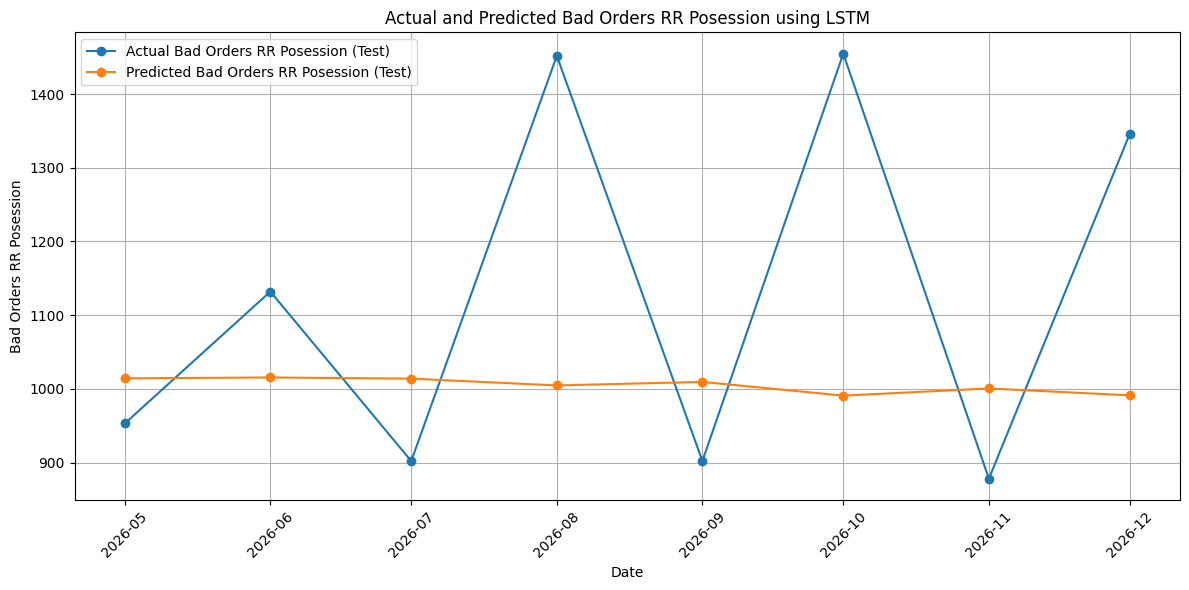

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load and prepare the data
data = pd.read_excel("TTX.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns={'Date': 'ds', 'Bad_orders_RR': 'y', 'Fleets_in_Service': 'Fleets_in_Service'}, inplace=True)
data['month'] = data['ds'].dt.month

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['y', 'Fleets_in_Service', 'month']])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Target variable is 'y'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Number of previous time steps to use as input features
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets
TRAIN_SPLIT = int(len(X) * 0.8)
X_train, X_test = X[:TRAIN_SPLIT], X[TRAIN_SPLIT:]
y_train, y_test = y[:TRAIN_SPLIT], y[TRAIN_SPLIT:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], 2)))))[:, 0]  # Inverse scaling

# Evaluate the model
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))[:, 0]
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['ds'][-len(y_test_actual):], y_test_actual, marker='o', linestyle='-', label='Actual Bad Orders RR Posession (Test)')
plt.plot(data['ds'][-len(y_pred):], y_pred, marker='o', linestyle='-', label='Predicted Bad Orders RR Posession (Test)')
plt.xlabel('Date')
plt.ylabel('Bad Orders RR Posession')
plt.title('Actual and Predicted Bad Orders RR Posession using LSTM')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
30/30 - 3s - 95ms/step - loss: 0.2381
Epoch 2/100
30/30 - 0s - 4ms/step - loss: 0.1723
Epoch 3/100
30/30 - 0s - 6ms/step - loss: 0.1287
Epoch 4/100
30/30 - 0s - 4ms/step - loss: 0.1010
Epoch 5/100
30/30 - 0s - 4ms/step - loss: 0.0850
Epoch 6/100
30/30 - 0s - 3ms/step - loss: 0.0768
Epoch 7/100
30/30 - 0s - 4ms/step - loss: 0.0732
Epoch 8/100
30/30 - 0s - 4ms/step - loss: 0.0719
Epoch 9/100
30/30 - 0s - 4ms/step - loss: 0.0715
Epoch 10/100
30/30 - 0s - 6ms/step - loss: 0.0714
Epoch 11/100
30/30 - 0s - 4ms/step - loss: 0.0714
Epoch 12/100
30/30 - 0s - 3ms/step - loss: 0.0714
Epoch 13/100
30/30 - 0s - 3ms/step - loss: 0.0715
Epoch 14/100
30/30 - 0s - 4ms/step - loss: 0.0715
Epoch 15/100
30/30 - 0s - 4ms/step - loss: 0.0715
Epoch 16/100
30/30 - 0s - 4ms/step - loss: 0.0715
Epoch 17/100
30/30 - 0s - 3ms/step - loss: 0.0715
Epoch 18/100
30/30 - 0s - 4ms/step - loss: 0.0715
Epoch 19/100
30/30 - 0s - 6ms/step - loss: 0.0715
Epoch 20/100
30/30 - 0s - 6ms/step - loss: 0.0715
Epoch 21

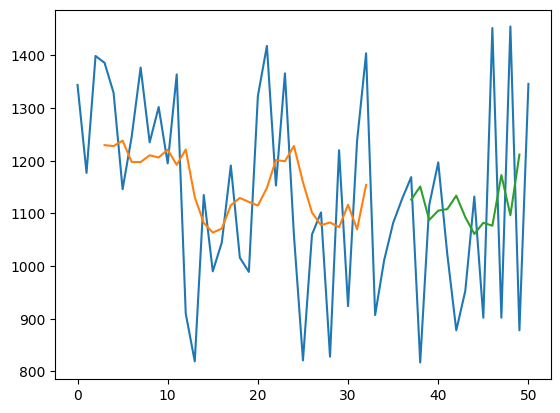

In [82]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = pd.read_excel('TTX.xlsx', usecols=[3])
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# LSTM for Regression with Time Steps

Epoch 1/100


C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 - 2s - 82ms/step - loss: 0.3744
Epoch 2/100
30/30 - 0s - 8ms/step - loss: 0.2969
Epoch 3/100
30/30 - 0s - 5ms/step - loss: 0.2351
Epoch 4/100
30/30 - 0s - 4ms/step - loss: 0.1856
Epoch 5/100
30/30 - 0s - 5ms/step - loss: 0.1470
Epoch 6/100
30/30 - 0s - 6ms/step - loss: 0.1184
Epoch 7/100
30/30 - 0s - 6ms/step - loss: 0.0989
Epoch 8/100
30/30 - 0s - 4ms/step - loss: 0.0869
Epoch 9/100
30/30 - 0s - 4ms/step - loss: 0.0804
Epoch 10/100
30/30 - 0s - 6ms/step - loss: 0.0772
Epoch 11/100
30/30 - 0s - 4ms/step - loss: 0.0758
Epoch 12/100
30/30 - 0s - 3ms/step - loss: 0.0753
Epoch 13/100
30/30 - 0s - 8ms/step - loss: 0.0751
Epoch 14/100
30/30 - 0s - 6ms/step - loss: 0.0750
Epoch 15/100
30/30 - 0s - 6ms/step - loss: 0.0749
Epoch 16/100
30/30 - 0s - 7ms/step - loss: 0.0749
Epoch 17/100
30/30 - 0s - 4ms/step - loss: 0.0748
Epoch 18/100
30/30 - 0s - 4ms/step - loss: 0.0748
Epoch 19/100
30/30 - 0s - 4ms/step - loss: 0.0747
Epoch 20/100
30/30 - 0s - 4ms/step - loss: 0.0746
Epoch 21/100
30/30 -

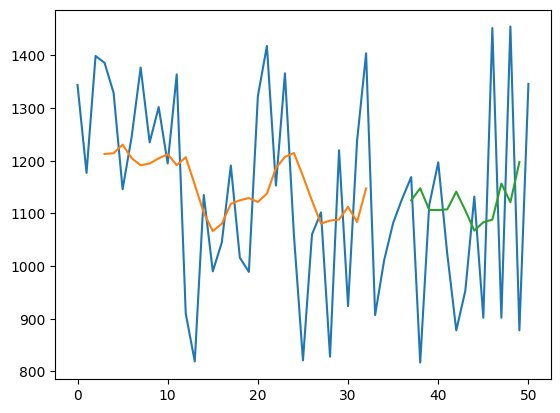

In [84]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = pd.read_excel('TTX.xlsx', usecols=[3])
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Multiple models used LSTM,Linear Regression, Random Forest and XGBoost

C:\Users\JeromGnanamanikam\anaconda3\envs\forecasting\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
LSTM:
  RMSE: 232.10
  MSE: 53870.12
  MAE: 201.68

Linear Regression:
  RMSE: 264.51
  MSE: 69966.41
  MAE: 215.89

Random Forest:
  RMSE: 234.63
  MSE: 55052.99
  MAE: 195.37

XGBoost:
  RMSE: 230.24
  MSE: 53009.61
  MAE: 192.95



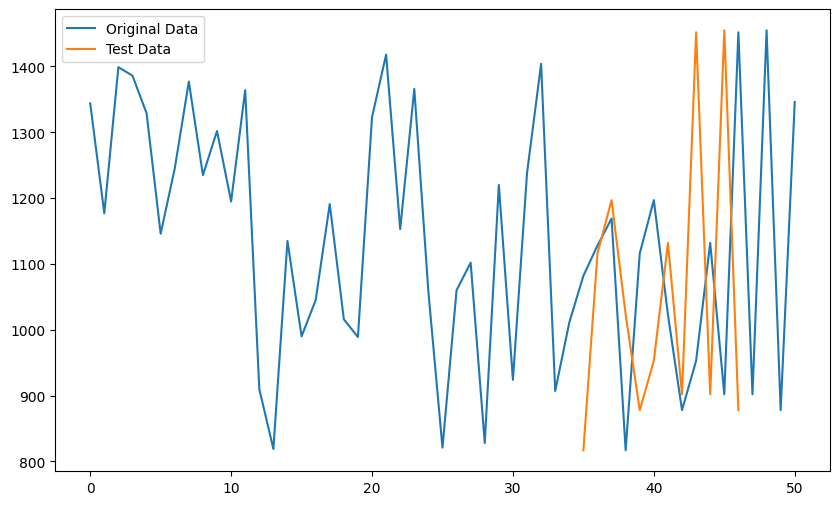

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Function to create dataset for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Fix random seed for reproducibility
np.random.seed(7)
tf.random.set_seed(7)

# Load the dataset (replace with your data loading mechanism)
dataframe = pd.read_excel('TTX.xlsx', usecols=[3])
dataset = dataframe.values.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# Linear Regression model
model_lr = LinearRegression()
model_lr.fit(trainX.reshape(-1, look_back), trainY)

# Random Forest model
model_rf = RandomForestRegressor(random_state=7)
model_rf.fit(trainX.reshape(-1, look_back), trainY)

# XGBoost model
model_xgb = XGBRegressor(random_state=7)
model_xgb.fit(trainX.reshape(-1, look_back), trainY)

# Function to calculate RMSE, MSE, and MAE
def evaluate_model(model, testX, testY, scaler):
    # Make predictions
    predictions = model.predict(testX.reshape(-1, look_back))
    predictions = predictions.reshape(-1, 1)
    
    # Invert predictions and testY to original scale
    predictions_inv = scaler.inverse_transform(predictions)
    testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(testY_inv, predictions_inv))
    mse = mean_squared_error(testY_inv, predictions_inv)
    mae = mean_absolute_error(testY_inv, predictions_inv)
    
    return rmse, mse, mae

# Evaluate models
models = {
    'LSTM': model_lstm,
    'Linear Regression': model_lr,
    'Random Forest': model_rf,
    'XGBoost': model_xgb
}

results = {}
for name, model in models.items():
    rmse, mse, mae = evaluate_model(model, testX, testY, scaler)
    results[name] = {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae
    }

# Print results
for name, result in results.items():
    print(f"{name}:")
    print(f"  RMSE: {result['RMSE']:.2f}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print()

# Plotting (optional)
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(train_size + np.arange(len(testY)), scaler.inverse_transform(testY.reshape(-1, 1)), label='Test Data')
#plt.plot(train_size + np.arange(len(testPredict)), testPredict, label='LSTM Predictions')
plt.legend()
plt.show()
